In [2]:
#import necessary libraries and Modules
from skimage import data, color, io
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import skeletonize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import cv2
import numpy as np
import pandas as pd
import os
import copy
import subprocess
import csv
import math
import importlib

from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk

from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import convolve

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from scipy.ndimage import minimum_filter, maximum_filter

import IdentificationFuncs as identify


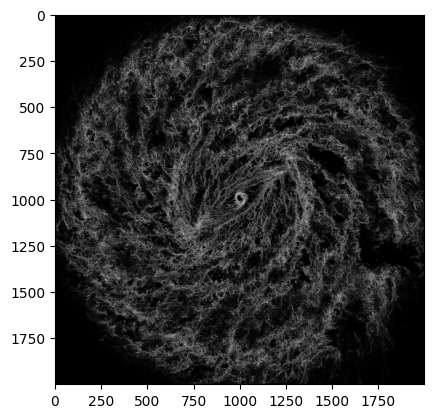

In [15]:

#Simulated galaxy file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"

#Actual galaxy file
# fits_file = r"c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\JWST_F770W_filamentenhanced_multiscale_examples (1)\Users\dthilker\python\Constrained-Diffusion-Decomposition-main\ngc4303_770_CDDss0016pc_arcsinh0p1_sato.fits"

#Plot
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU
plt.imshow(np.flipud(image_data), cmap = 'gray')
plt.show()

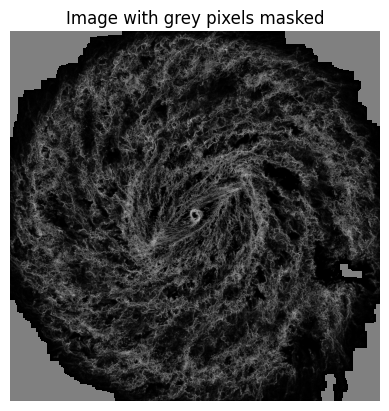

In [6]:
importlib.reload(identify)

#threshold for pixel values to mask
threshold = .03 # for simulated image
#threshold = 10^-4 # for real image
dilated_data, mask = identify.dilateBlankRegions(image_data, threshold)


In [32]:

data = copy.deepcopy(image_data.astype(np.float64)) #photutils should take float64

#subtract bkg
scalepix = 1.6 #16pc/(10pc/pix)
bkg_estimator = MedianBackground()
bkg = Background2D(data, box_size=round(10.*scalepix/2.)*2+1, filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background #subtract bkg
data[data < 0] = 0 #Elimate neg values. This is over estimating the background and messes up fits files

#scale the bkg subtracted data
topval=np.nanpercentile(data[data!=0],99.999)
datascl=data*65535/topval

#save scaled data to png
datascl = datascl.astype(np.uint16)
input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\GalaxySimScl_16bit16pc.png"
cv2.imwrite(input_image, datascl)

#save scaled data to fits
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\GalaxySim16pc.fits'
fits.writeto(fits_file_path, datascl, overwrite=True)

#scaled data stats: 
meanval,medianval,stddevval= sigma_clipped_stats(datascl[datascl!=0],sigma=3,maxiters=None)
print(medianval,stddevval)

#bkg sub/RMS map
noise = bkg.background_rms
noise[noise == 0] = 10**-10 #replace with random number...if noise = 0, we are in background, and output will be set to 0 anyway

divRMS = data/noise
divRMS[mask] = 0 #masked regions are zero...can change to some reasonable value but doesn't really matter for SOAX

print(f'div RMS max: {np.max(noise)}, RMS min excluding 0: {np.min(noise[noise != 10**-10])} ') #min and max are different than those on google collab...why?

fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\GalaxySim16pcbkg_divRMSMap.fits'
fits.writeto(fits_file_path, divRMS.astype(np.float64), overwrite=True)

#bkg map
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\GalaxySim16pcbkgMap.fits'
fits.writeto(fits_file_path, bkg.background, overwrite=True)

#RMS map
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\GalaxySim16pcRMSMap.fits'
fits.writeto(fits_file_path, bkg.background_rms, overwrite=True)

print("DONE!")

6226.0 7297.426948307628
div RMS max: 0.19031617477362506, RMS min excluding 0: 1.0223723723496242e-06 
DONE!


In [3]:
input_image = input_image #taken from above

batch = r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe"
# param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files"
param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params"

for param_file in os.listdir(param_dir):
    # Use numpy.arange() to generate floating-point values
    # Split the file name into base name and extension
    base_name, extension = os.path.splitext(param_file)

    # Print the base name without extension
    # output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\results\{base_name}"
    output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\{base_name}"

    assert(os.path.isdir(output_dir))
    # parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files\{param_file}"
    parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\{param_file}"

    assert( os.path.isfile(parameter_file))
    assert( os.path.isfile(input_image))

    cmdString = f'"{batch}" soax -i "{input_image}" -p "{parameter_file}" -s "{output_dir}" --ridge 0.005 0.01 0.04 --stretch 3.0 0.5 4.0'
    print("starting SOAX")
    subprocess.run(cmdString, shell=True)  # Use shell=True if command needs shell features
    print(f'{param_file} complete')


fits saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\bkgSub16noScl.fits
fits
starting SOAX


KeyboardInterrupt: 

In [2]:
import subprocess
import pandas as pd 

result_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results"
# Define the expected header line for identification
expected_header = "s p x y z fg_int bg_int"

for result_folder in os.listdir(result_dir):
    result_folder = os.path.join(result_dir, result_folder)
    for result_file in os.listdir(result_folder):
        if(result_file.endswith('.txt')):
            input_file_path = os.path.join(result_folder, result_file)
            print(f' wprking on {input_file_path}')
            assert( os.path.isfile(input_file_path))
            
            base_name, extension = os.path.splitext(input_file_path)
            output_file_path = output_dir = fr'{result_folder}\{result_file}To_csv.csv'

            # Read the content of the input file
            with open(input_file_path, 'r') as file:
                lines = file.readlines()

            # Find the index where the header starts
            header_start_index = None
            for i, line in enumerate(lines):
                # Normalize line by stripping extra spaces
                normalized_line = ' '.join(line.split())

                if normalized_line == expected_header:
                    header_start_index = i
                if "[" in line:
                    stopper_index = i
                    break

            if header_start_index is None:
                print('HEADER NOT FOUND!')
                continue

            # Extract header and data
            header_and_data = lines[header_start_index:stopper_index]

            # Write to CSV
            with open(output_file_path, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                
                for line in header_and_data:
                    # Split columns by whitespace (assuming whitespace is the delimiter)
                    row = line.split()
                    csv_writer.writerow(row)

            print(f"{result_file} has been saved to {output_file_path}")

            df = pd.read_csv(output_file_path)
            # Convert coordinates to float
            x_coords = df["x"].astype(float)
            y_coords = df["y"].astype(float)

            # Filter out NaN values and convert to integers
            x_coords_cleaned = [int(round(x)) for x in x_coords if not pd.isna(x)]
            y_coords_cleaned = [int(round(y)) for y in y_coords if not pd.isna(y)]
            assert(len(x_coords_cleaned)==len(y_coords_cleaned))
            coordinates = list(zip(x_coords_cleaned,y_coords_cleaned))


            gray_image = np.zeros_like(image_data)
            # Step 3: Color the coordinates purple
            # Ensure coordinates are within the image bounds
            for (y,x) in coordinates:
                if 0 <= x < gray_image.shape[0] and 0 <= y < gray_image.shape[1]:
                    gray_image[x, y] = 1

            
            fits_file_path = output_dir = fr'{result_folder}\{result_file}To_fits.fits'

            fits.writeto(fits_file_path, gray_image, overwrite=True)
            print(f'fits saved to {fits_file_path}')

 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txt
ThresholdedImage--ridge0.005000--stretch2.500.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txtTo_csv.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_50228\1145482826.py:53: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file_path)


fits saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txtTo_fits.fits
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txt
ThresholdedImage--ridge0.005000--stretch3.000.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txtTo_csv.csv
fits saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txtTo_fits.fits
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.01500--stretch2.500.txt
ThresholdedImage--ridge0.01500--stretch2.500.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.01500--

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research\\SOAX_results\\best_results\\best_param1.fits'